<!-- # 全连接神经网络数据分析（最后转成英文） -->
# Fully Connected Neural Network Data Analysis

<!-- 在之前的章节中，我们介绍了神经网络的基本概念、以及如何对其进行编程。在这一章节中，我们以上市公司税收不遵从行为的分类为例，用```torch```展示神经网络的内部工作机制，并借此简单介绍```torch```的基本用法。 -->

In previous sections, we introduced the basic concepts of neural networks and how to programe them manually. Now in this section, we would demonstrate the usage of ```PyTorch``` as an example of **tax non-compliant company classification** .

**Learning Goal**：
* a
* b
* c

## 目录

<a name='1'></a>
## 1-Import Packages

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
torch.manual_seed(42)

<a name='2'></a>
## 2-Descriptive Analysis

我们使用的数据包括2015-2024年中国所有上市公司的财报指标和纳税违规公告。在原始数据中，税收遵从企业的数量。通过上采样，最终得到的数据集data.csv中包含4155条税收遵从企业和831条不遵从企业的观测记录。

下面我们先使用```pandas```读取数据文件，再展示数据集的前5条观测值，以对数据产生初步认识。

In [2]:
train_df = pd.read_csv('train_data.csv') # 读取训练数据
test_df = pd.read_csv('test_data.csv') # 读取测试数据
train_df.head(5) # 展示训练数据前5行

,noncompliance,股东权益/负债合计_EquTotLia,股东类别_SHType,每股收益(元/股)_BasicEPS,每股经营活动现金流量(元/股)_OpeCFPS,营业利润/营业总收入()_OpePrTOR,净利润()_NetPrf,有形净值债务率(%)_DbTanEquRt,每股现金及现金等价物余额(元/股)_CCEPS,资产负债率(%)_DbAstRt,...,股东权益周转率(次)_EquRat,产权比率(%)_DbEquRt,权益乘数(%)_EquMul,营业收入3年复合增长率(%)_OperaInc3GrRt,净资产收益率(扣除，加权)(%)_WROECut,流动资产/总资产(%)_CurTotAst,销售成本率(%)_SalCostRt,销售毛利率(%)_GIncmRt,销售期间费用率(%)_PdCostRt,非流动资产/总资产(%)_NoncurTotAst
0,0.0,80.7537,0,0.0588,0.0753,3.9793,1.015744e+08,133.4197,0.3359,55.1437,...,1.9469,122.9342,2.2293,90.2712,5.18,69.1845,88.9524,11.0476,8.1304,30.8155
1,0.0,323.5963,0,0.7400,0.3335,13.3080,1.517207e+07,31.6858,0.9271,23.6074,...,1.3302,30.9027,1.3090,52.6485,21.05,75.3315,39.3969,60.6031,44.1717,24.6685
2,0.0,40.9974,0,-2.0400,1.0992,-21.5082,-9.471246e+08,364.3200,0.8515,71.0248,...,1.9207,245.1222,3.4512,9.2016,-47.12,53.5268,79.3969,20.6031,20.5129,46.4732
3,0.0,68.6448,0,1.2704,1.9955,12.4332,1.143370e+08,192.2331,0.6467,59.2962,...,2.5506,145.6775,2.4568,8.3138,22.84,46.1873,73.8741,26.1259,15.2662,53.8127
4,0.0,12.2972,1,-0.8900,-0.1791,-14.3990,-2.031099e+08,6375.7392,0.5305,86.7773,...,4.1962,656.2752,7.5628,-3.9599,-60.48,72.8318,96.3563,3.6437,12.5189,27.1682


在该数据集中，```noncompliance``` 变量是我们关心的Y变量，```noncompliance = 1```代表该企业在当年存在着税收不遵从行为。

我们按照```noncompliance```变量进行分组，在每组中计算样本均值。可以发现税收不遵从的企业和税收遵从的企业在股权结构、偿债能力、盈利能力等方面都可能存在着不同。

In [3]:
train_df.groupby('noncompliance').mean().round(3).T # 按照noncompliance分组计算均值，取3位小数

noncompliance,0.0,1.0
股东权益/负债合计_EquTotLia,2.489180e+02,1.584320e+02
股东类别_SHType,2.530000e-01,1.660000e-01
每股收益(元/股)_BasicEPS,5.000000e-01,3.160000e-01
每股经营活动现金流量(元/股)_OpeCFPS,6.320000e-01,4.650000e-01
营业利润/营业总收入()_OpePrTOR,-2.709000e+00,-2.671000e+00
净利润()_NetPrf,4.212471e+08,7.623510e+08
有形净值债务率(%)_DbTanEquRt,4.213800e+01,2.824480e+02
每股现金及现金等价物余额(元/股)_CCEPS,1.734000e+00,2.053000e+00
资产负债率(%)_DbAstRt,4.087700e+01,4.953700e+01
经营现金净流量(元)_NOCF,8.465880e+08,1.123684e+09


<a name='3'></a>
## 3-建模分析

In [5]:
# 将data数据框转换为numpy数组
X_train_array = train_df.drop(columns=['noncompliance']).values
y_train_array = train_df['noncompliance'].values
X_test_array = test_df.drop(columns=['noncompliance']).values
y_test_array = test_df['noncompliance'].values

scaler = StandardScaler()
X_train_array = scaler.fit_transform(X_train_array)  # 计算均值和方差并标准化
X_test_array = scaler.transform(X_test_array) # 使用训练集的均值和方差来标准化测试集

# 将 numpy数组转换为 pytorch tensor
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

# 将pytorch tensor 转换为 pytorch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(25, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # relu激活函数
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x)) # sigmoid激活函数
        # x = self.fc3(x)
        return x

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train(model, train_loader, criterion, optimizer, num_epochs, device="cpu"):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0

        y_true_epoch = []
        y_pred_epoch = []

        for batch_idx, (data, target) in enumerate(train_loader):
            data   = data.to(device)
            target = target.to(device).float()          # BCELoss 需要 float 标签

            optimizer.zero_grad()
            prob   = model(data)                       # ⬅️ 已经是 [0,1] 概率
            loss   = criterion(prob.squeeze(1), target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # -------- 收集预测 ----------
            preds = (prob.detach().squeeze(1) >= 0.5).long()
            y_true_epoch.append(target.detach().cpu())
            y_pred_epoch.append(preds.cpu())
            # ----------------------------

        avg_loss = total_loss / num_batches

        y_true = torch.cat(y_true_epoch).numpy()
        y_pred = torch.cat(y_pred_epoch).numpy()

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall    = recall_score(y_true, y_pred, zero_division=0)
        f1        = f1_score(y_true, y_pred, zero_division=0)

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                  f"Loss: {avg_loss:.4f} | "
                  f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f}")

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

def test(model, test_loader, criterion, device="cpu", thresh=0.5):
    model.to(device)
    model.eval()

    total_loss = 0.0
    n_batches  = 0

    all_probs   = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data    = data.to(device)
            target  = target.to(device).float()

            prob    = model(data).squeeze(1)
            loss    = criterion(prob, target)
            total_loss += loss.item()
            n_batches += 1

            all_probs.extend(prob.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # ---- 依据阈值生成 0/1 预测 ----
    all_preds = (np.array(all_probs) >= thresh).astype(int)
    all_targets = np.array(all_targets).astype(int)

    # ---- 指标 ----
    test_loss = total_loss / n_batches
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall    = recall_score(all_targets, all_preds, zero_division=0)
    f1        = f1_score(all_targets, all_preds, zero_division=0)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f} | "
          f"Recall: {recall:.4f} | "
          f"F1: {f1:.4f}")
    print("Number of predicted positives:", all_preds.sum())
    print("Number of actual positives:",   all_targets.sum())

In [9]:
model = FNN() # 实例化模型
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([4])) # 二分类交叉熵损失函数
criterion = nn.BCELoss() # 二分类交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam优化器


In [10]:
train(model, train_loader, criterion, optimizer, num_epochs=500) # 训练模型

Epoch [50/500] | Loss: 0.1606 | P: 0.8343 R: 0.5006 F1: 0.6258
Epoch [100/500] | Loss: 0.1305 | P: 0.8696 R: 0.6120 F1: 0.7184
Epoch [150/500] | Loss: 0.1093 | P: 0.9045 R: 0.6847 F1: 0.7794
Epoch [200/500] | Loss: 0.0989 | P: 0.9103 R: 0.7204 F1: 0.8043
Epoch [250/500] | Loss: 0.0895 | P: 0.9131 R: 0.7501 F1: 0.8236
Epoch [300/500] | Loss: 0.0842 | P: 0.9231 R: 0.7650 F1: 0.8366
Epoch [350/500] | Loss: 0.0881 | P: 0.9180 R: 0.7760 F1: 0.8411
Epoch [400/500] | Loss: 0.0694 | P: 0.9370 R: 0.8088 F1: 0.8682
Epoch [450/500] | Loss: 0.0686 | P: 0.9361 R: 0.8096 F1: 0.8683
Epoch [500/500] | Loss: 0.0650 | P: 0.9348 R: 0.8168 F1: 0.8719


In [11]:
test(model, test_loader, criterion)

Test Loss: 0.5347
Precision: 0.3694 | Recall: 0.3892 | F1: 0.3790
Number of predicted positives: 509
Number of actual positives: 483


In [12]:
def get_probs_targets(model, loader, device="cpu"):
    """返回两个 np.array: 预测概率 probs, 真实标签 targets"""
    model.eval()
    model.to(device)

    probs   = []
    targets = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float()

            p = model(x).squeeze(1)          # 你的网络已带 sigmoid → p∈[0,1]
            probs.extend(p.cpu().numpy())
            targets.extend(y.cpu().numpy())

    return np.array(probs), np.array(targets, dtype=int)

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score

probs, y_true = get_probs_targets(model, test_loader, device = 'cpu')

precision, recall, thresholds = precision_recall_curve(y_true, probs)
auc_pr  = average_precision_score(y_true, probs)

print(f"PR‑AUC = {auc_pr:.4f}")

PR‑AUC = 0.2745


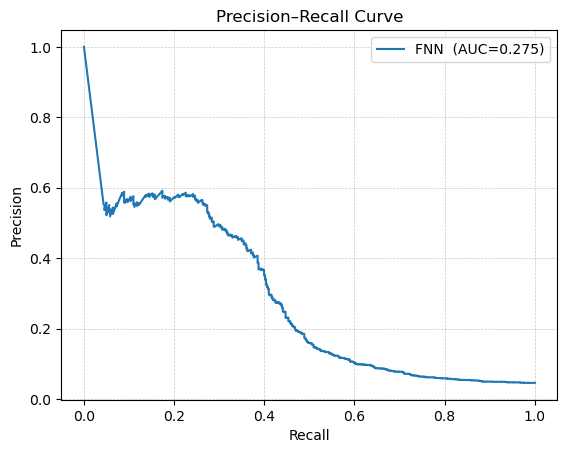

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(recall, precision, label=f"FNN  (AUC={auc_pr:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

## 4-模型比较